# CNN_mat
*this notebook will implement deep learning on the preprocessed svhn data and train a model that can recognize house number*

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle
import tensorflow as tf
from sklearn import linear_model as lr
from sklearn.metrics import confusion_matrix, classification_report
import display_center
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<br \>
## Step 1 Load Data From Pickle
<br \>

In [2]:
# unpack the data from files
def unpickle(file_name):
    print("loading %s" %file_name)
    try:
        with open(file_name, "rb") as f:
            data = pickle.load(f)
            print("SUCCESS!")
            return data['X'].astype(np.float32), data['y'].astype(np.float32)
    except Exception as e:
        print("FAILED: ", e)
        

In [3]:
train_X, train_y = unpickle("train.pickle")
print(train_X.shape, train_y.shape)
val_X, val_y = unpickle("validation.pickle")
print(val_X.shape, val_y.shape)
test_X, test_y = unpickle("test.pickle")
print(test_X.shape, test_y.shape)

loading train.pickle
SUCCESS!
(100000, 32, 32) (100000,)
loading validation.pickle
SUCCESS!
(6000, 32, 32) (6000,)
loading test.pickle
SUCCESS!
(26032, 32, 32) (26032,)


*** Display Some Images to Make Sure They're Good ***

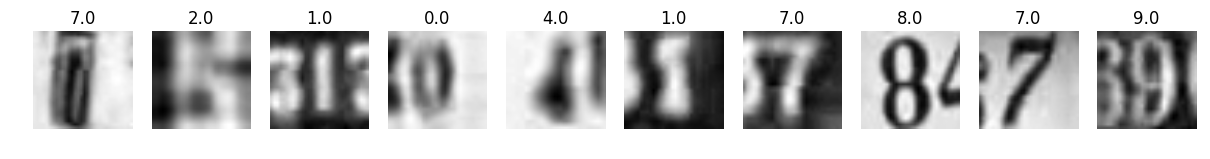

In [4]:
display_center.sample_display(train_X, train_y, plt = plt)

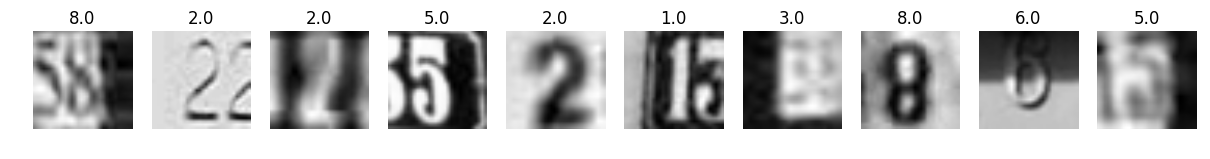

In [5]:
display_center.sample_display(val_X, val_y, plt)

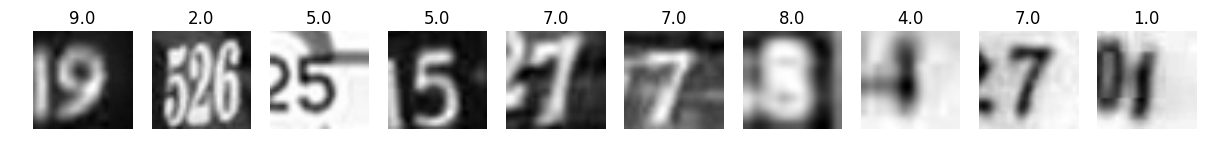

In [6]:
display_center.sample_display(test_X, test_y, plt)

<br \>
## Step 2 Run A Linear Classifier on The Data 
<br \>

In [7]:
# before do a heavy cnn, it's better to check how a sgdclassifier perform
def no_nn(X, y, valX, valy):
    train_X = X.reshape([X.shape[0], -1])
    val_X = valX.reshape([valX.shape[0], -1])
    train_y = y
    val_y = valy
    clf = lr.SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, shuffle=True, verbose=0,\
                           random_state=None, learning_rate='optimal')
    clf.fit(train_X, train_y)
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    print('Training score is', clf.score(train_X, train_y))
    print('Validation score is', clf.score(val_X, val_y))

    print('Classification report of training data:\n', classification_report(train_y, train_pred))
    print('Confusion Matrix of training data:\n', confusion_matrix(train_y, train_pred))

    print('Classification report of validation data:\n', classification_report(val_y, val_pred))
    print('Confusion Matrix of validation data:\n', confusion_matrix(val_y, val_pred))
    
    

In [8]:
no_nn(train_X, train_y, val_X, val_y)

Training score is 0.16768
Validation score is 0.143
Classification report of training data:
              precision    recall  f1-score   support

        0.0       0.12      0.33      0.17     10000
        1.0       0.14      0.32      0.20     10000
        2.0       0.36      0.13      0.19     10000
        3.0       0.30      0.03      0.06     10000
        4.0       0.58      0.12      0.20     10000
        5.0       0.37      0.10      0.16     10000
        6.0       0.31      0.12      0.17     10000
        7.0       0.46      0.11      0.18     10000
        8.0       0.12      0.38      0.18     10000
        9.0       0.38      0.04      0.07     10000

avg / total       0.31      0.17      0.16    100000

Confusion Matrix of training data:
 [[3264 2463   98   39   71   85  384  123 3394   79]
 [2413 3181  308   23  150  164  228  180 3309   44]
 [2538 2203 1319   65  113  129  185  196 3188   64]
 [2666 2263  300  314   94  379  198  220 3459  107]
 [2475 2305  278  10

<br \>

<br \>


## Step 3 Build a CNN model
the next cell will build a computational graph for cnn

In [9]:
# before building the graph, reshape the image
imsize = 32
train_X = train_X.reshape([-1, imsize, imsize, 1])
test_X = test_X.reshape([-1, imsize, imsize, 1])
val_X = val_X.reshape([-1, imsize, imsize, 1])
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(100000, 32, 32, 1)
(26032, 32, 32, 1)
(6000, 32, 32, 1)


In [10]:
# ohe the y
num_labels = 10
num_channels = 1
def ohe(y):
    y = y.reshape([-1, 1])
    return (np.arange(num_labels) == y).astype(np.float32)
train_y = ohe(train_y)
test_y = ohe(test_y)
val_y = ohe(val_y)

<br \>
### accuracy function definition

In [11]:
def accuracy(pred, y):
    return 100.0 * np.sum(np.argmax(y, axis = 1) == np.argmax(pred, axis = 1))/float(y.shape[0])

<br \>
### the model

def variable_summaries(var, name):
    '''Attach summaries to a Tensor'''
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        

In [22]:
batch_size = 256
patch_size = [5, 5, 3]
depth = [32, 64, 256]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-drop-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    # Variables
    # f for filter, b for bias
    f1 = tf.Variable(tf.truncated_normal([patch_size[0], patch_size[0], num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    f2 = tf.Variable(tf.truncated_normal([patch_size[1], patch_size[1], depth[0], depth[1]], stddev = 0.05))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    f3 = tf.Variable(tf.truncated_normal([patch_size[2], patch_size[2], depth[1], depth[2]], stddev = 0.07))
    b3 = tf.Variable(tf.zeros([depth[2]]))
    fc1_w = tf.Variable(tf.truncated_normal([imsize//16*imsize//16*depth[-1], num_hidden], stddev = 0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.2))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        conv = tf.nn.conv2d(relu, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        conv = tf.nn.conv2d(dropped, f3, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b3)
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')      
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        dropped = tf.nn.dropout(reshape, .5) if drop else reshape
        hidden = tf.nn.relu(tf.matmul(dropped, fc1_w) + fc1_b)
        return tf.matmul(hidden, fc2_w) + fc2_b
    
    
    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 500, .98, staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step = global_step)
    train_pred = tf.nn.softmax(model(net_train_X))
    
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    
    saver = tf.train.Saver()

*the next cell will run the graph in a tensorflow session*

In [23]:
num_steps = 30001
log_steps = 500
log = {'train_loss': [], 'val_acc':[], 'test_acc': 0.00}
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialize') 
    for step in range(num_steps):
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size)]
        
        feed_dict = {net_train_X : batch_X, net_train_y : batch_y}
        
        _, stage_loss, pred = session.run([optimizer, loss, train_pred], feed_dict=feed_dict)
        if (step % 50 == 0):
            val_acc = accuracy(val_pred.eval(), val_y)
            log['val_acc'].append(val_acc)
            log['train_loss'].append(stage_loss)        
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, stage_loss))
            print('Minibatch accuracy: %.1f%%' % accuracy(pred, batch_y))
            print('Validation accuracy: %.1f%%' % val_acc)

            
    test_acc = accuracy(test_pred.eval(), test_y)        
    print('Test accuracy: %.1f%%' % test_acc)
    save_path = saver.save(session, ("CNN_%.2f.ckpt" %test_acc))
    print('Model saved in file %s' % save_path)
    log['test_acc'] = test_acc

Initialize
Minibatch loss at step 0: 3.965193
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.716075
Minibatch accuracy: 83.2%
Validation accuracy: 85.0%
Minibatch loss at step 1000: 0.422404
Minibatch accuracy: 93.8%
Validation accuracy: 87.9%
Minibatch loss at step 1500: 0.267747
Minibatch accuracy: 95.7%
Validation accuracy: 89.6%
Minibatch loss at step 2000: 0.513037
Minibatch accuracy: 86.7%
Validation accuracy: 92.0%
Minibatch loss at step 2500: 0.470174
Minibatch accuracy: 90.6%
Validation accuracy: 92.1%
Minibatch loss at step 3000: 0.175056
Minibatch accuracy: 96.1%
Validation accuracy: 92.4%
Minibatch loss at step 3500: 0.116524
Minibatch accuracy: 97.7%
Validation accuracy: 92.7%
Minibatch loss at step 4000: 0.419175
Minibatch accuracy: 92.6%
Validation accuracy: 92.7%
Minibatch loss at step 4500: 0.119051
Minibatch accuracy: 97.7%
Validation accuracy: 93.2%
Minibatch loss at step 5000: 0.174708
Minibatch accuracy: 98.4%
Validation accuracy

In [32]:
test_prediction = None
with tf.Session(graph = graph) as sess:
    saver.restore(sess, 'CNN_95.25.ckpt')
    test_prediction = test_pred.eval()

test_yy = np.argmax(test_y, axis = 1)
test_prediction = np.argmax(test_prediction, axis = 1)
print('Classification report of testing data:\n', classification_report(test_yy, test_prediction))
print('Confusion Matrix of testing data:\n', confusion_matrix(test_yy, test_prediction))

Classification report of testing data:
              precision    recall  f1-score   support

          0       0.90      0.97      0.93      1744
          1       0.97      0.95      0.96      5099
          2       0.98      0.96      0.97      4149
          3       0.95      0.92      0.94      2882
          4       0.97      0.96      0.96      2523
          5       0.97      0.94      0.96      2384
          6       0.94      0.95      0.94      1977
          7       0.94      0.97      0.95      2019
          8       0.93      0.93      0.93      1660
          9       0.93      0.95      0.94      1595

avg / total       0.95      0.95      0.95     26032

Confusion Matrix of testing data:
 [[1693    7    1    4    3    2   11    6    4   13]
 [  62 4856   23   18   36   11    7   65   17    4]
 [   6   21 4003   35   19    1    7   32    9   16]
 [  14   27   19 2665    8   34   18   10   46   41]
 [  17   30   12    2 2432    2    4   10    6    8]
 [   7   13    9   44

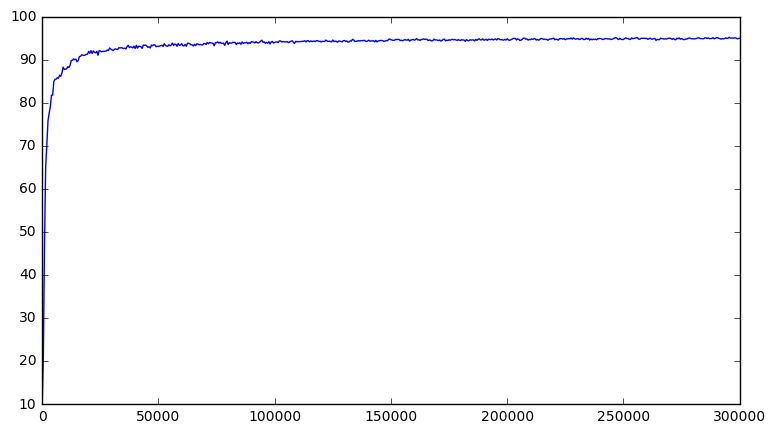

In [33]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.plot(log_steps*np.arange(len(log['val_acc'])), log['val_acc'])